In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import sys
print(sys.executable)


C:\Users\PC\Desktop\ml_project\venv\Scripts\python.exe


In [26]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14', 'RSI_30',
       'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change',
       'Log_Returns', 'Volatility_10', 'Volatility_30', 'Future_Close',
       'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [27]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [28]:
y = y.replace({2: 1})  # Replace '2' with '1'


In [29]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [30]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [31]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8748, 15)
y_train shape: (8748,)


## LightGboost

In [32]:
from lightgbm import LGBMClassifier
from sklearn.base import is_classifier

# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Check if the model is a classifier
print(is_classifier(model))  # Should return True

True


In [33]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss 
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Num

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Hyperparameter

In [34]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Numb

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}
Best Score: 0.8371048925916851


##  Rebuild the model with Hyperparameters 

In [35]:
# Train the model with the best parameters
LightGBM = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
LightGBM.fit(X_train_scaled, y_train)

# Make predictions
y_pred = LightGBM.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191
Accuracy on Test Data with Tuned Parameters: 0.8446069469835467


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


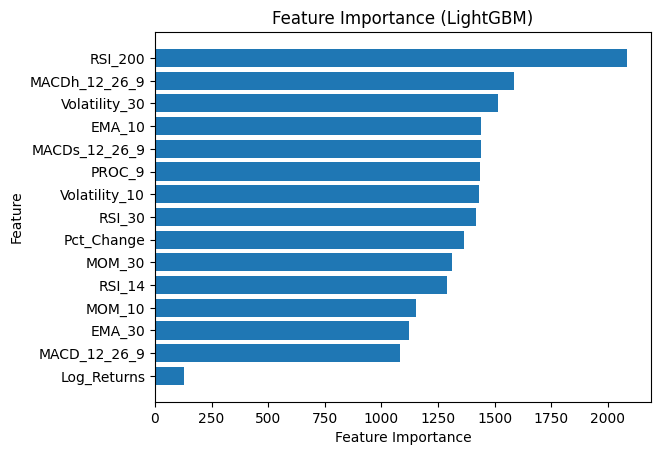

In [36]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = LightGBM.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


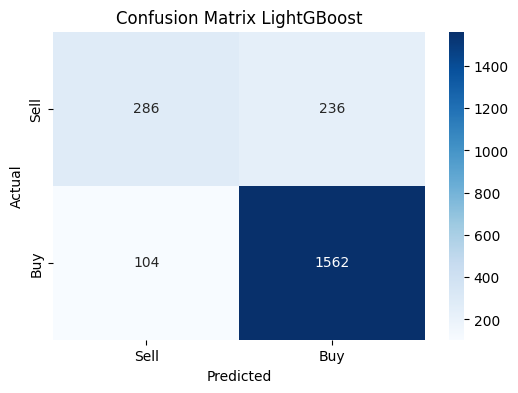

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix LightGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [38]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix as a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 286                 236
Actual Positive                 104                1562


In [39]:
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 84.46%

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63       522
           1       0.87      0.94      0.90      1666

    accuracy                           0.84      2188
   macro avg       0.80      0.74      0.76      2188
weighted avg       0.84      0.84      0.84      2188



In [40]:
# Assuming the test set represents the latest data points
start_index = len(data) - len(y_test)  # Find where the test set starts
date_range = pd.date_range(start='2024-01-01', periods=len(y_test), freq='D')  # Generate artificial dates

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'date': date_range,  # Using a fake date range (adjust as needed)
    'actual_price': y_test.values,  # If y_test is classification, replace with actual close price
    'predicted_price': y_pred,
    'decision': ['BUY' if pred == 1 else 'SELL' for pred in y_pred],
    'confidence': LightGBM.predict_proba(X_test_scaled)[:, 1]  # Probability of "BUY"
})


# Save to CSV
predictions_df.to_csv("C:/Users/PC/Desktop/ml_project/Algorithm_Trading_ML/data/final_predictions.csv", index=False)

print("Predictions saved successfully!")


Predictions saved successfully!


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [41]:
predictions_df

,date,actual_price,predicted_price,decision,confidence
0,2024-01-01,1,1,BUY,0.999967
1,2024-01-02,1,1,BUY,0.682488
2,2024-01-03,0,1,BUY,0.938157
3,2024-01-04,1,1,BUY,0.999959
4,2024-01-05,0,1,BUY,0.892932
...,...,...,...,...,...
2183,2029-12-23,1,0,SELL,0.260569
2184,2029-12-24,0,0,SELL,0.042536
2185,2029-12-25,1,1,BUY,0.990968
2186,2029-12-26,1,1,BUY,0.965781


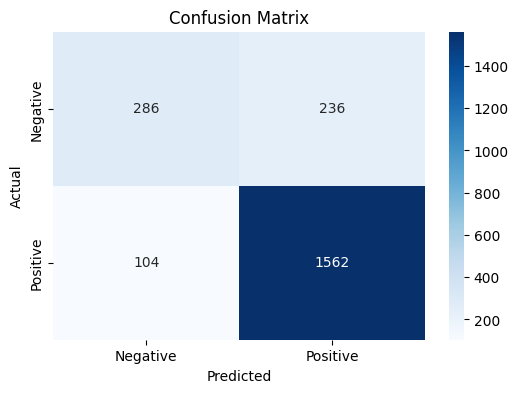

In [42]:
# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 2. XGBoost Model


In [43]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


In [44]:
# Step 1: Define the list of features and target variable
features = [
    'RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns',
    'Volatility_10', 'Volatility_30'
]
X = data[features]
y = data['Signal'].replace({2: 1})  # Map '2' to '1' for binary classification


In [45]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [46]:
# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [47]:
# Step 4: Define the Optuna optimization function
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    
    # Perform cross-validation using xgb.cv
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    
    # Return the mean of the test logloss
    return cv_results['test-logloss-mean'].min()


In [48]:
# Step 5: Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study.optimize(objective, n_trials=50) 

# Step 6: Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-02-25 19:42:59,986] A new study created in memory with name: XGBoost Hyperparameter Tuning
[I 2025-02-25 19:43:56,628] Trial 0 finished with value: 0.41858616858335473 and parameters: {'booster': 'dart', 'eta': 0.02924137836638166, 'max_depth': 10, 'min_child_weight': 5.728878612499425, 'subsample': 0.6522910573078798, 'colsample_bytree': 0.9991759047277637, 'lambda': 0.130985716663197, 'alpha': 0.0025220966930690814}. Best is trial 0 with value: 0.41858616858335473.
[I 2025-02-25 19:43:57,949] Trial 1 finished with value: 0.43418598757191373 and parameters: {'booster': 'gbtree', 'eta': 0.0864365880410684, 'max_depth': 4, 'min_child_weight': 3.007568777739051, 'subsample': 0.9584438016658328, 'colsample_bytree': 0.8491762975604837, 'lambda': 2.3238145757694904, 'alpha': 0.19134556017615184}. Best is trial 0 with value: 0.41858616858335473.
[I 2025-02-25 19:44:28,034] Trial 2 finished with value: 0.43237744831165 and parameters: {'booster': 'dart', 'eta': 0.13175259090879524, 'm

Best Hyperparameters: {'booster': 'dart', 'eta': 0.11902359774671993, 'max_depth': 10, 'min_child_weight': 1.8924372962494518, 'subsample': 0.9141793183839484, 'colsample_bytree': 0.9723434413924222, 'lambda': 0.04923453679696845, 'alpha': 0.0030986616770971743}


In [49]:
# Step 7: Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  # Avoid deprecation warning
})
XGBoost = xgb.XGBClassifier(**best_params, random_state=42)
XGBoost.fit(X_train_scaled, y_train)


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0030986616770971743, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9723434413924222, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.11902359774671993, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.04923453679696845, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1.8924372962494518, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [50]:
# Step 8: Evaluate the model on the test set
y_pred = XGBoost.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 0.8409506398537477

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.51      0.60       511
           1       0.86      0.94      0.90      1677

    accuracy                           0.84      2188
   macro avg       0.80      0.72      0.75      2188
weighted avg       0.83      0.84      0.83      2188



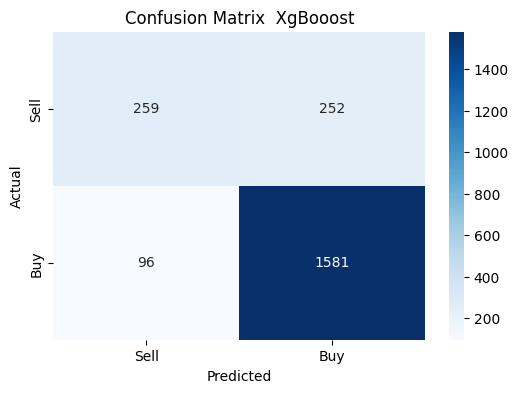

In [51]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [52]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


def objectiveRD(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestClassifier(**params, random_state=42)
    
    # Evaluation 
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    
    return -np.mean(scores)  # Minimiser la log loss


study = optuna.create_study(direction="minimize")
study.optimize(objectiveRD, n_trials=50)

[I 2025-02-25 19:57:49,369] A new study created in memory with name: no-name-09375512-d614-40ee-9a2b-75b77517f1d7
[I 2025-02-25 19:58:21,037] Trial 0 finished with value: 0.46626228517359236 and parameters: {'n_estimators': 145, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.46626228517359236.
[I 2025-02-25 19:59:19,134] Trial 1 finished with value: 2.1299184536234064 and parameters: {'n_estimators': 143, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.46626228517359236.
[I 2025-02-25 19:59:52,896] Trial 2 finished with value: 0.412886926223303 and parameters: {'n_estimators': 166, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.412886926223303.
[I 2025-02-25 19:59:54,364] Trial 3 finished with value: 0.4473685910908839 

In [53]:
from sklearn.ensemble import RandomForestClassifier  

best_params = study.best_params

best_params.update({
    'random_state': 42
})

# Créer et entraîner le modèle final avec les meilleurs hyperparamètres
rf_model = RandomForestClassifier(**best_params)  
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(bootstrap=False, max_depth=19, max_features='log2',
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=158, random_state=42)

In [54]:
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.8569469835466179

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.54      0.64       511
           1       0.87      0.95      0.91      1677

    accuracy                           0.86      2188
   macro avg       0.83      0.75      0.77      2188
weighted avg       0.85      0.86      0.85      2188



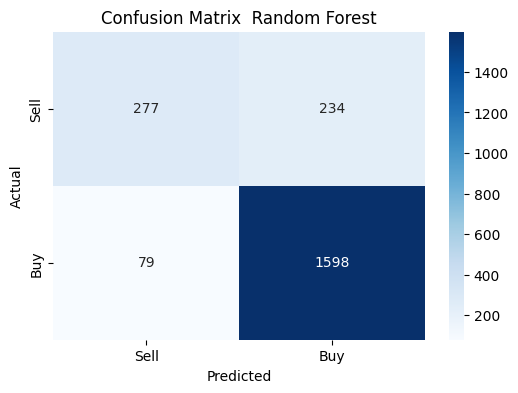

In [55]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Final Model (The best Model)

In [56]:
'''
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) 
at different thresholds showing how well a model can distinguish between two 
classes such as positive and negative outcomes.

'''


'\nIt plots the True Positive Rate (TPR) against the False Positive Rate (FPR) \nat different thresholds showing how well a model can distinguish between two \nclasses such as positive and negative outcomes.\n\n'

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


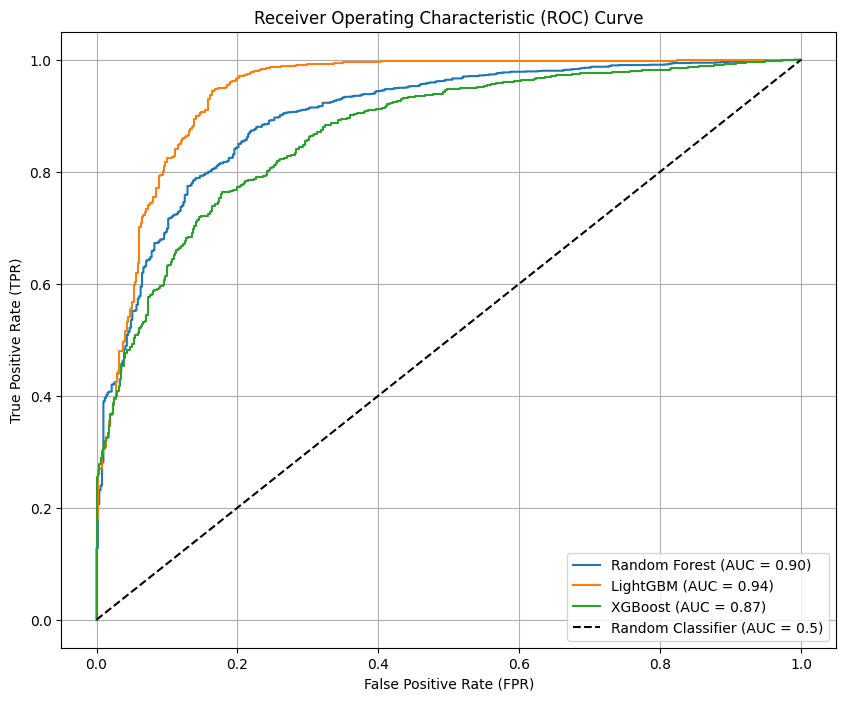

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Your trained models
models = [rf_model, LightGBM, XGBoost]  # Update model names accordingly
model_names = ['Random Forest', 'LightGBM', 'XGBoost']

# Placeholder for actual predicted probabilities
model_probabilities = [
    rf_model.predict_proba(X_test_scaled),  # Random Forest
    LightGBM.predict_proba(X_test_scaled),  # LightGBM
    XGBoost.predict_proba(X_test_scaled)    # XGBoost
]

# Prepare a figure for plotting
plt.figure(figsize=(10, 8))

for i, model in enumerate(models):
    # Get the predicted probabilities for the positive class (class 1)
    y_prob = model_probabilities[i][:, 1]  # Assuming it's a binary classification model
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Compute the AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# Labels and Title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In [58]:
# Save the model for future use
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved successfully.")
  


NameError: name 'joblib' is not defined

In [ ]:
import joblib

# Save the trained model
joblib.dump(LightGBM, "lightgbm_aapl_model.pkl")

# Load it later for predictions
loaded_model = joblib.load("lightgbm_aapl_model.pkl")
